# Similarity Calculation

$d_1, d_2$: JSON documents

Wanted: $sim(d_1, d_2) \in [0,1]$

For every key $k$:
$sim_k(d_1, d_2) \in [0, 1]$

We could define $sim$ as averaging over all $sim_k$:

$$sim_k'(d_1, d_2) = \begin{cases}
sim_k(d_1, d_2) \text{ falls } k \in d_1 \text{ und } k \in d_2\\
0 \text{ sonst}
\end{cases}$$

$$sim(d_1, d_2) = \frac{\sum_{k \in d_1 \cup d_2} sim_k'(d_1, d_2)}{|d_1 \cup d_2|}$$

Types of attribute values:
- Categorical values
- Numerical (with metric units)
- Numerical (without metric units)
- Lists of categorical values

Categorical Values:

$$sim_k(d_1, d_2) = \begin{cases}1 \text{ falls } d_1[k] = d_2[k]\\
0 \text{ sonst}
\end{cases}$$

Numerical (with metric units) => convert into standard units (z.B. g, mm)

Numerical (without metric units)

- calculate quotient of both numbers

$$sim_k(d_1, d_2) = \begin{cases}
\frac{d_1[k]}{d_2[k]} \text{ if } d_1[k] \leq d_2[k]\\
\frac{d_2[k]}{d_1[k]} \text{ otherwise }
\end{cases}$$

- or, find range of values for key
    - Difference of both document values in relation to the whole range
    
$$sim_k(d_1, d_2) = 1 - \frac{|(d_1[k]-d_2[k])|}{k_\text{max}-k_\text{min}}$$

- or, find distribution of values for key
    - Number of standard deviations inbetween the two document values?

Lists: ratio of elements in common

$$sim_k(d_1, d_2) = \frac{|d_1[k] \cap d_2[k]|}{|d_1[k] \cup d_2[k]|}$$

## Implementation Decisions
Similarity between two documents:
- sim is calculated over union of keys of both parts, not intersection
- sim in attributes that only one part of both has is 0 (not 0.5)
- numerical values with units are converted to standard units, then taken as quotient of both (not difference divided by range size)
- no weights on keys
- only look at the 25 most occurring keys
- could also take weight for each component from FMDs (weight is not in the top 25)
- using difference similarity for numerical only, using quotient similarity for numerical with metric units

Similarity within a cluster:
- calculate similarity between all documents in the cluster, average, standard deviation
- create a generalized version of attributes as a general part for the cluster, with distribution of values across each attribute (mean, standard deviation, mode or median (if applicable))

### Reading the octopart data

In [1]:
import os, json
from tqdm import tqdm

octopart_directory = '../octopart/'
octopart_data = []

for filename in tqdm(os.listdir(octopart_directory)):
    if filename.endswith(".json"):
        with open(octopart_directory + filename, encoding="utf8") as json_file:
            octopart_data.append(json.load(json_file))

100%|██████████| 19913/19913 [00:19<00:00, 1022.01it/s]


In [2]:
counts = {"companion_products" : [], "datasheets" : [], "descriptions" : [], "images": [], "reference_designs" : [], "similar_parts": [], "specs" : []}
tech_specs = {}
for part in octopart_data:
    for counted in part["counts"].keys():
        counts[counted].append(part["counts"][counted])
    for spec in part["specs"]:
        attribute = spec["attribute"]
        attr_name = attribute["name"]
        if not attr_name in tech_specs:
            tech_specs[attr_name] = {}
            tech_specs[attr_name]["group"] = attribute["group"]
            tech_specs[attr_name]["values"] = []
            tech_specs[attr_name]["count"] = 0
        tech_specs[attr_name]["values"].append(spec["display_value"])
        tech_specs[attr_name]["count"] += 1

### The top 25 attributes

In [3]:
specs_with_counts = [(tech_specs[key]["count"], key) for key in tech_specs.keys()]
attribute_names = [x[1] for x in sorted(specs_with_counts, reverse = True)]# [:25]]

In [4]:
attribute_names

['RoHS',
 'Max Operating Temperature',
 'Min Operating Temperature',
 'Mount',
 'Radiation Hardening',
 'Lifecycle Status',
 'Case/Package',
 'Packaging',
 'Lead Free',
 'Number of Pins',
 'Length',
 'Termination',
 'Contact Plating',
 'Manufacturer Lifecycle Status',
 'ELV',
 'Operating Supply Voltage',
 'Frequency',
 'REACH SVHC',
 'Orientation',
 'Max Frequency',
 'Number of Positions',
 'Interface',
 'Data Bus Width',
 'Height',
 'Depth',
 'RAM Size',
 'Number of Contacts',
 'Housing Color',
 'Max Supply Voltage',
 'Number of Rows',
 'Contact Material',
 'Color',
 'Min Supply Voltage',
 'Memory Type',
 'Housing Material',
 'Weight',
 'Memory Size',
 'Connector Type',
 'Halogen Free',
 'Current Rating',
 'Flammability Rating',
 'Gender',
 'Pitch',
 'Width',
 'Number of Timers/Counters',
 'Number of I/Os',
 'Sealable',
 'Core Architecture',
 'Voltage Rating',
 'Peripherals',
 'Oscillator Type',
 'Schedule B',
 'Number of Programmable I/O',
 'Contact Current Rating',
 'Plating',
 'Con

### Getting these attributes from each part, deleting the 11 parts from other manufacturers

In [5]:
company_to_short = {
    'TE Connectivity' : "TE",
    'TE Connectivity / AMP' : "TE", 
    'TE Connectivity / Raychem' : "TE", 
    'TE Connectivity / Alcoswitch' : "TE",
    'TE Connectivity / DEUTSCH' : "TE", 
    'TE Connectivity / Holsworthy' : "TE",
    'TE Connectivity / Citec' : "TE", 
    'TE Connectivity / Corcom' : "TE", 
    'OEG' : "TE",
    'NXP Semiconductors' : 'NXP',
    'Nexperia' : "NXP", 
    'Freescale Semiconductor' : "NXP"}

In [6]:
part_attributes = {}
for part in octopart_data:
    manufacturer_name = part['manufacturer']['name']
    if manufacturer_name in company_to_short:
        cmp_short = company_to_short[manufacturer_name]
        key = cmp_short + '_' + part["mpn"]
        part_attributes[key] = {}
        for spec in part["specs"]:
            attribute = spec["attribute"]
            if attribute["name"] in attribute_names:
                part_attributes[key][attribute["name"]] = spec["display_value"]
    else:
        print(part['manufacturer']['name'])

Sensata / Airpax
HARTING Elektronik
EDAC
Molex
Phoenix Contact
EDAC
Festo
WAGO
Idec
Festo
Hubbell Wiring Device-Kellems


In [7]:
part_attributes

{'NXP_S9S08DZ32F2CLF': {'Case/Package': 'LQFP',
  'Data Bus Width': '8 b',
  'Halogen Free': 'Halogen Free',
  'Interface': 'CAN, I2C, SCI, SPI',
  'Max Frequency': '40 MHz',
  'Max Operating Temperature': '85 °C',
  'Memory Size': '32 kB',
  'Memory Type': 'FLASH',
  'Min Operating Temperature': '-40 °C',
  'Number of Programmable I/O': '40',
  'Number of Timers/Counters': '2',
  'RAM Size': '2 kB',
  'RoHS': 'Compliant',
  'Watchdog Timer': 'Yes'},
 'TE_794012-1': {'Approvals': 'CSA',
  'Color': 'Black',
  'Connector System': 'Wire-to-Wire',
  'Connector Type': 'Pin',
  'Contact Gender': 'Female',
  'Contact Retention': 'Without',
  'Contact Style': 'Pin',
  'Depth': '23.88 mm',
  'ELV': 'Compliant',
  'Fastening Type': 'Latch',
  'Flammability Rating': 'UL94 V-2',
  'Gender': 'Receptacle',
  'Height': '23.622 mm',
  'Housing Color': 'Black, Natural',
  'Housing Material': 'Nylon',
  'Lead Free': 'Not Applicable',
  'Length': '13.081 mm',
  'Lifecycle Status': 'Production (Last Updat

### Automating, whether an attribute is categorical, numerical, numerical with metrics, or list of categories

In [8]:
CAT = "Categorical"
NUM = "Numerical"
NWMU = "Numerical with Metric Units"
LOC = "List of Categories"

In [48]:
import re

attr_to_type = {}
attr_to_values = {}
attr_to_metric = {}
for attribute_name in attribute_names:
    guess = None
    attr_to_values[attribute_name] = set()
    for part in part_attributes.keys():
        if attribute_name in part_attributes[part].keys():
            part_attr = part_attributes[part][attribute_name]
            
            # matching integers, not floats!
            if re.match("^0$|^([1-9]\d*)$", part_attr):
                current_guess = NUM
            # matching pos/neg integers or floats with metric units from 1 - 3 letters
            elif re.match("^[-+]?[0-9]*[\.|,]?[0-9]+ [° µ Ω % A-Z a-z /]{1,7}$", part_attr):
                current_guess = NWMU
            # matching comma and space separated lists of digit-letter combinations
            # could also try to split at ", " 
            elif re.match("^([A-Z a-z 0-9 \- / \|]+, )+[A-Z a-z 0-9 \- / \|]*$", part_attr):
                current_guess = LOC
            else: 
                current_guess = CAT

            if not guess:
                guess = current_guess
            
            # looking whether guess needs to be overridden
            if guess != current_guess:
                if guess == CAT and current_guess == LOC:
                    print("Overriding CAT because of", part_attr)
                    guess = LOC
                elif guess == NUM and current_guess == CAT:
                    print("Overriding NUM because of", part_attr)
                    guess = CAT
                    # override data types in set
                    attr_to_values[attribute_name] = set([str(value) for value in list(attr_to_values[attribute_name])])
                elif guess == NUM and current_guess == LOC:
                    print("Overriding NUM because of", part_attr)
                    guess = LOC
                    # override data types in set
                    attr_to_values[attribute_name] = set([str(value) for value in list(attr_to_values[attribute_name])])
                elif guess == LOC and current_guess == NUM or guess == LOC and current_guess == CAT or guess == CAT and current_guess == NUM:
                    pass
                else:
                    print(guess, "does not match", current_guess, "for", part_attr, attribute_name)

            if guess == NUM:
                value = [int(part_attr)]
            elif guess == NWMU:
                value = [float(part_attr.split(" ")[0])]
                metric = [part_attr.split(" ")[1]]
                if not attribute_name in attr_to_metric.keys():
                    attr_to_metric[attribute_name] = set()
                attr_to_metric[attribute_name].update(metric)
            elif guess == CAT:
                value = [part_attr]
            elif guess == LOC:
                value = part_attr.split(", ")
            
            attr_to_values[attribute_name].update(value)
            
    attr_to_type[attribute_name] = guess
    if not guess:
        del attr_to_values[attribute_name]
    print(guess, "for", attribute_name)

Categorical for RoHS
Numerical with Metric Units for Max Operating Temperature
Numerical with Metric Units for Min Operating Temperature
Overriding CAT because of Screw, Through Hole
List of Categories for Mount
Categorical for Radiation Hardening
Categorical for Lifecycle Status
Categorical for Case/Package
Categorical for Packaging
Overriding CAT because of Lead Free, Not Applicable
List of Categories for Lead Free
Numerical for Number of Pins
Numerical with Metric Units for Length
Overriding CAT because of Kinked Pin, Press-Fit, Solder
List of Categories for Termination
List of Categories for Contact Plating
Categorical for Manufacturer Lifecycle Status
Categorical for ELV
Numerical with Metric Units for Operating Supply Voltage
Numerical with Metric Units for Frequency
Categorical for REACH SVHC
Overriding CAT because of Straight, Vertical
List of Categories for Orientation
Numerical with Metric Units for Max Frequency
Numerical for Number of Positions
List of Categories for Interf

List of Categories for Logic Function
Numerical with Metric Units for Test Frequency
Numerical for Number of Ethernet Channels
Categorical for Type
Numerical for Number of Pairs
Overriding CAT because of Normal, Standard
List of Categories for Polarity
Categorical for Thread Size
Numerical for Number of Levels
Numerical with Metric Units for P1dB
Categorical for Differential Signaling
Overriding CAT because of Over Temperature, Over Voltage
List of Categories for Fault Protection
Categorical for Direction
Numerical with Metric Units for Outside Diameter
Numerical with Metric Units for Termination Post Length
Numerical with Metric Units for Max Output Current
Overriding CAT because of X, Y
List of Categories for Axis
Numerical for Number of Wire Entries
Numerical for Differential Pairs per Column
Numerical with Metric Units for Drain to Source Breakdown Voltage
Categorical for Polarized
Categorical for Output Configuration
Categorical for High Temperature Compatible
Categorical for Shel

Numerical for Number of Amplifiers
Categorical for Guide Hardware
Categorical for Gender Type B
Categorical for Gender Type A
Categorical for Gasket
Numerical with Metric Units for Bundle Diameter
Numerical with Metric Units for Battery Pack Voltage
Numerical with Metric Units for Switching Voltage
Numerical for Number of Analog Outputs
Numerical for Number of Analog Inputs
Numerical with Metric Units for Flange Diameter
Numerical with Metric Units for Conductor Diameter
Numerical with Metric Units for Board Thickness
Numerical with Metric Units for Actuator Diameter
Categorical for Turns Ratio
Numerical with Metric Units for Time to Trip
Categorical for Taper
Numerical for Number of LEDs
Numerical with Metric Units for Load Capacitance
Numerical with Metric Units for Linearity
List of Categories for Lens Style
Numerical with Metric Units for Hold Current
Categorical for Fuse
Numerical with Metric Units for Forward Voltage
Categorical for Evaluation Kit
Numerical with Metric Units for 

In [49]:
attr_to_type

{'RoHS': 'Categorical',
 'Max Operating Temperature': 'Numerical with Metric Units',
 'Min Operating Temperature': 'Numerical with Metric Units',
 'Mount': 'List of Categories',
 'Radiation Hardening': 'Categorical',
 'Lifecycle Status': 'Categorical',
 'Case/Package': 'Categorical',
 'Packaging': 'Categorical',
 'Lead Free': 'List of Categories',
 'Number of Pins': 'Numerical',
 'Length': 'Numerical with Metric Units',
 'Termination': 'List of Categories',
 'Contact Plating': 'List of Categories',
 'Manufacturer Lifecycle Status': 'Categorical',
 'ELV': 'Categorical',
 'Operating Supply Voltage': 'Numerical with Metric Units',
 'Frequency': 'Numerical with Metric Units',
 'REACH SVHC': 'Categorical',
 'Orientation': 'List of Categories',
 'Max Frequency': 'Numerical with Metric Units',
 'Number of Positions': 'Numerical',
 'Interface': 'List of Categories',
 'Data Bus Width': 'Numerical with Metric Units',
 'Height': 'Numerical with Metric Units',
 'Depth': 'Numerical with Metric Unit

In [50]:
attr_to_values

{'RoHS': {'Compliant', 'Non-Compliant'},
 'Max Operating Temperature': {-130.0,
  -125.0,
  -105.0,
  -70.0,
  30.0,
  50.0,
  60.0,
  65.0,
  70.0,
  75.0,
  80.0,
  85.0,
  90.0,
  95.0,
  100.0,
  104.0,
  105.0,
  110.0,
  115.0,
  120.0,
  125.0,
  130.0,
  135.0,
  140.0,
  150.0,
  155.0,
  160.0,
  165.0,
  167.0,
  170.0,
  175.0,
  176.0,
  185.0,
  194.0,
  200.0,
  203.0,
  212.0,
  221.0,
  225.0,
  230.0,
  235.0,
  248.0,
  250.0,
  257.0,
  260.0,
  266.0,
  340.0,
  343.0,
  482.0,
  649.0,
  650.0},
 'Min Operating Temperature': {-85.0,
  -75.0,
  -67.0,
  -65.0,
  -55.0,
  -50.0,
  -45.0,
  -40.0,
  -35.0,
  -30.0,
  -28.88,
  -25.0,
  -22.0,
  -20.0,
  -13.0,
  -10.0,
  -4.0,
  0.0,
  10.0,
  20.0,
  32.0,
  105.0,
  131.0,
  140.0},
 'Mount': {'Adhesive',
  'Axial',
  'Board Lock',
  'Box',
  'Brackets',
  'Bulkhead',
  'Bushing',
  'Cable',
  'Chassis',
  'Chassis Mount',
  'Clamp',
  'Clip',
  'DIN Rail',
  'Edge',
  'External',
  'Flanges',
  'Free Hanging',
  '

In [12]:
attr_to_metric

{'Max Operating Temperature': {'°C'},
 'Min Operating Temperature': {'°C'},
 'Length': {'m', 'mm', 'µm'},
 'Operating Supply Voltage': {'V', 'kV'},
 'Frequency': {'GHz', 'Hz', 'MHz', 'kHz'},
 'Max Frequency': {'GHz', 'MHz', 'kHz'},
 'Data Bus Width': {'b'},
 'Height': {'m', 'mm', 'µm'},
 'Depth': {'mm', 'µm'},
 'RAM Size': {'B', 'GB', 'MB', 'kB'},
 'Max Supply Voltage': {'V', 'mV'},
 'Min Supply Voltage': {'V', 'mV'},
 'Weight': {'g', 'mg', 'µg'},
 'Memory Size': {'B', 'MB', 'kB'},
 'Current Rating': {'A', 'mA', 'µA'},
 'Pitch': {'mm', 'µm'},
 'Width': {'mm', 'µm'},
 'Voltage Rating': {'V', 'kV', 'mV'},
 'Contact Current Rating': {'A', 'mA'},
 'Row Spacing': {'m', 'mm', 'µm'},
 'Wire Gauge (Min)': {'AWG'},
 'Wire Gauge (Max)': {'AWG'},
 'Plating Thickness': {'m', 'mm', 'nm', 'µm'},
 'Max Voltage Rating (AC)': {'V', 'kV'},
 'PCB Thickness': {'mm', 'µm'},
 'Insulation Diameter': {'mm', 'µm'},
 'Max Power Dissipation': {'W', 'kW', 'mW'},
 'Insulation Resistance': {'GΩ', 'MΩ', 'TΩ', 'kΩ', 

In [13]:
from scripts.substance_handling import save_json
from scripts.constants import COMPONENT_JSON_FOLDER
save_json(COMPONENT_JSON_FOLDER + "oct_attribute_to_type.json", attr_to_type)

In [14]:
import scripts.substance_handling
attr_to_values_save = {key: list(value) for key, value in attr_to_values.items()}
scripts.substance_handling.save_json(COMPONENT_JSON_FOLDER + "oct_attribute_to_values.json", attr_to_values_save)

In [15]:
import scripts.substance_handling
attr_to_metric_save = {key: list(value) for key, value in attr_to_metric.items()}
scripts.substance_handling.save_json(COMPONENT_JSON_FOLDER + "oct_attribute_to_metric.json", attr_to_metric_save)

In [16]:
# extract base metrics from attr with metric units
# take smallest metric string from all that occur -> base metric
# or if multiple have same length, but nothing is smallest, check whether all prefixes are modifiers, then basemetric without modifiers
base_metrics = {}
for attr, atype in attr_to_type.items():
    if atype == NWMU:
        values = attr_to_metric[attr]
        if len(values) == 1:
            # if we only have one metric, take it as base metric and never convert
            metric = list(values)[0]
            print("Only", metric, "for", attr)
        else:
            if len(set(len(string) for string in values)) > 1:
                # if we have multiple metrics with different lengths, the shortest must be the base metric
                metric = min(values, key=len)
                print("Shortest", metric, "for", attr)
            else:
                # we have multiple metrics all with the same lengths, which means they all have different modifiers
                metrics = set(string[1:] for string in values)
                if len(metrics) == 1:
                    metric = list(metrics)[0]
                    print("Base", metric, "for", attr)
                else:
                    raise Exception("Something went wrong trying to figure out the base metric for", attr, "with", values)
        if metric == "":
            raise Exception("Something went wrong splitting metric and modifier, resulting metric is empty for", attr)
        base_metrics[attr] = metric

Only °C for Max Operating Temperature
Only °C for Min Operating Temperature
Shortest m for Length
Shortest V for Operating Supply Voltage
Shortest Hz for Frequency
Base Hz for Max Frequency
Only b for Data Bus Width
Shortest m for Height
Base m for Depth
Shortest B for RAM Size
Shortest V for Max Supply Voltage
Shortest V for Min Supply Voltage
Shortest g for Weight
Shortest B for Memory Size
Shortest A for Current Rating
Base m for Pitch
Base m for Width
Shortest V for Voltage Rating
Shortest A for Contact Current Rating
Shortest m for Row Spacing
Only AWG for Wire Gauge (Min)
Only AWG for Wire Gauge (Max)
Shortest m for Plating Thickness
Shortest V for Max Voltage Rating (AC)
Base m for PCB Thickness
Base m for Insulation Diameter
Shortest W for Max Power Dissipation
Base Ω for Insulation Resistance
Shortest V for Voltage Rating (DC)
Only AWG for Wire/Cable Gauge
Shortest Ω for Resistance
Shortest W for Power Rating
Only % for Tolerance
Shortest A for Max Current Rating
Only ppm/°C f

In [18]:
from decimal import *
from scripts.constants import METRIC_MODIFIER_TO_FACTOR
getcontext().prec = 10

def convert_metrics(value: str, base_metric: str) -> float:
    number, metric = value.split(" ")
    number = Decimal(number)
    if metric != base_metric:
        if len(metric) > 1 and metric[0] in METRIC_MODIFIER_TO_FACTOR and metric[1:] == base_metric:
            modifier = metric[0]
            factor = METRIC_MODIFIER_TO_FACTOR[modifier]
            number *= factor
        else:
            print("Unknown metric or modifier in", value)
    
    if int(number) == float(number):
        return int(number)
    else:
        return float(number)
        
    return (results, base_metric)

In [51]:
from numpy import isclose
def preprocess_oct_dict(oct_dict):
    new_dict = {}
    for attribute in oct_dict['specs']:
        new_dict[attribute['attribute']['name']] = attribute['display_value']
    return new_dict

#CAT = "Categorical"
#NUM = "Numerical"
#NWMU = "Numerical with Metric Units"
#LOC = "List of Categories"

def get_quotient(value1, value2):
    # divide smaller value by larger value
    if isclose(value1, value2, rtol=1e-05, atol=1e-08, equal_nan=False):
        return 1
    if value1 < value2:
        if isclose(value2, 0, rtol=1e-05, atol=1e-08, equal_nan=False):
            return 0
        return value1/value2
    else:
        if isclose(value1, 0, rtol=1e-05, atol=1e-08, equal_nan=False):
            return 0
        return value2/value1
    
def get_difference_in_range(value1, value2, min_value, max_value):
    # 1 - diff / max-min of attribute
    return 1 - abs(value1 - value2) / (max_value - min_value)

def compare_attr(attr_name, value1, value2, verbose = False):
    value_type = attr_to_type[attr_name]
    if value_type == CAT:
        # check whether categories are the same or not, 0 or 1
        return int(value1 == value2)
    elif value_type == NUM:
        value1 = int(value1)
        value2 = int(value2)
        # return get_difference_in_range(value1, value2, max(attr_to_values[attr_name]) - min(attr_to_values[attr_name]))
        return get_quotient(value1, value2)
    elif value_type == NWMU:
        # convert into comparable numbers, remove metric unit
        # TODO: not convert if both have the same modifier
        value1 = convert_metrics(value1, base_metrics[attr_name])
        value2 = convert_metrics(value2, base_metrics[attr_name])
        
        # scale both values if the minimal value of this attribute is below zero (e.g. for temperatures)
        min_of_attr = float(min(attr_to_values[attr_name]))
        if min_of_attr < 0:
            value1 = value1 - min_of_attr
            value2 = value2 - min_of_attr
        if verbose:
            print(value1, value2, min_of_attr, get_quotient(value1, value2))
        return get_quotient(value1, value2)
    elif value_type == LOC:
        # intersection / union of values
        value1 = value1.split(', ')
        value2 = value2.split(', ')
        len_intersection = len(set(value1).intersection(value2))
        # print("LOC:", len_intersection, len(value1)+len(value2), value1, ",", value2)
        return len_intersection / (len(value1) + len(value2) - len_intersection)
    

def compare_octoparts(json_file1, json_file2, verbose=False):
    dict1 = preprocess_oct_dict(json_file1)
    dict2 = preprocess_oct_dict(json_file2)
    
    intersection_attributes = 0
    union_attributes = len(dict1) + len(dict2)
    similarity = 0
    if union_attributes == 0:
        # both have no attributes so similarity cannot be determined correctly
        # but if comparing a part to itself, it should be 1
        return 1
    
    for key in dict1.keys():
        if key in dict2:
            #compare both attributes
            attr_sim = compare_attr(key, dict1[key], dict2[key], verbose)
            similarity += attr_sim
            if verbose:
                print("Sim", attr_to_type[key], attr_sim, "for", dict1[key], "|", dict2[key])
            intersection_attributes += 1
            
    union_attributes -= intersection_attributes
    if verbose:
        print("End Sim:", similarity, intersection_attributes, union_attributes)
    similarity /= union_attributes
    return similarity

In [52]:
from tqdm import tqdm
n = 100 # len(octopart_data)
sim_table = [[0 for i in range(n)]for j in range(n)]
for i, part1 in tqdm(enumerate(octopart_data[:n])):
    for j, part2 in enumerate(octopart_data[:n]):
        sim_table[i][j] = compare_octoparts(part1, part2)
        if i == j and sim_table[i][j] != 1:
            raise Exception("Comparing part to itself did not result in sim of 1!")
        if sim_table[i][j] < 0:
            compare_octoparts(octopart_data[i], octopart_data[j], verbose=True)
            raise Exception("Sim below 0!")

100it [00:02, 38.68it/s]


In [53]:
for i in range(n):
    print(sim_table[i])

[1.0, 0.03870260793337717, 0.044515812480485306, 0.19077537593984964, 0.5474703990864287, 0.20947315096251265, 0.4994636954515849, 0.038461538461538464, 0.0, 0.3611111111111111, 0.2430560246163083, 0.05242973469923825, 0.0, 0.0, 0.28506680209838303, 0.12153086525307798, 0.2982450555979968, 0.04718676122931442, 0.04718676122931442, 0.060526315789473685, 0.08067375886524822, 0.07481940144478845, 0.11372549019607843, 0.05764411027568922, 0.0, 0.0, 0.08135648487812831, 0.0, 0.0, 0.20422247023809526, 0.16013071895424838, 0.1015406162464986, 0.17578857630008524, 0.05438558402084238, 0.069875860573535, 0.11071428571428571, 0.027077986261659727, 0.1619385342789598, 0.045454545454545456, 0.18434141951429184, 0.0, 0.09588312704509888, 0.03870260793337717, 0.0, 0.0, 0.16281512605042017, 0.023809523809523808, 0.0, 0.2805803571428572, 0.0, 0.047619047619047616, 0.3677469725453036, 0.0641025641025641, 0.03225806451612903, 0.0, 0.1538689353946707, 0.07142857142857142, 0.07142857142857142, 0.089814814

In [55]:
from random import sample

octopart_samples = sample(octopart_data, 1000)
sample_sims = []
for i in range(len(octopart_samples)):
    for j in range(i + 1,len(octopart_samples)):
        sample_sims.append(compare_octoparts(octopart_samples[i], octopart_samples[j]))

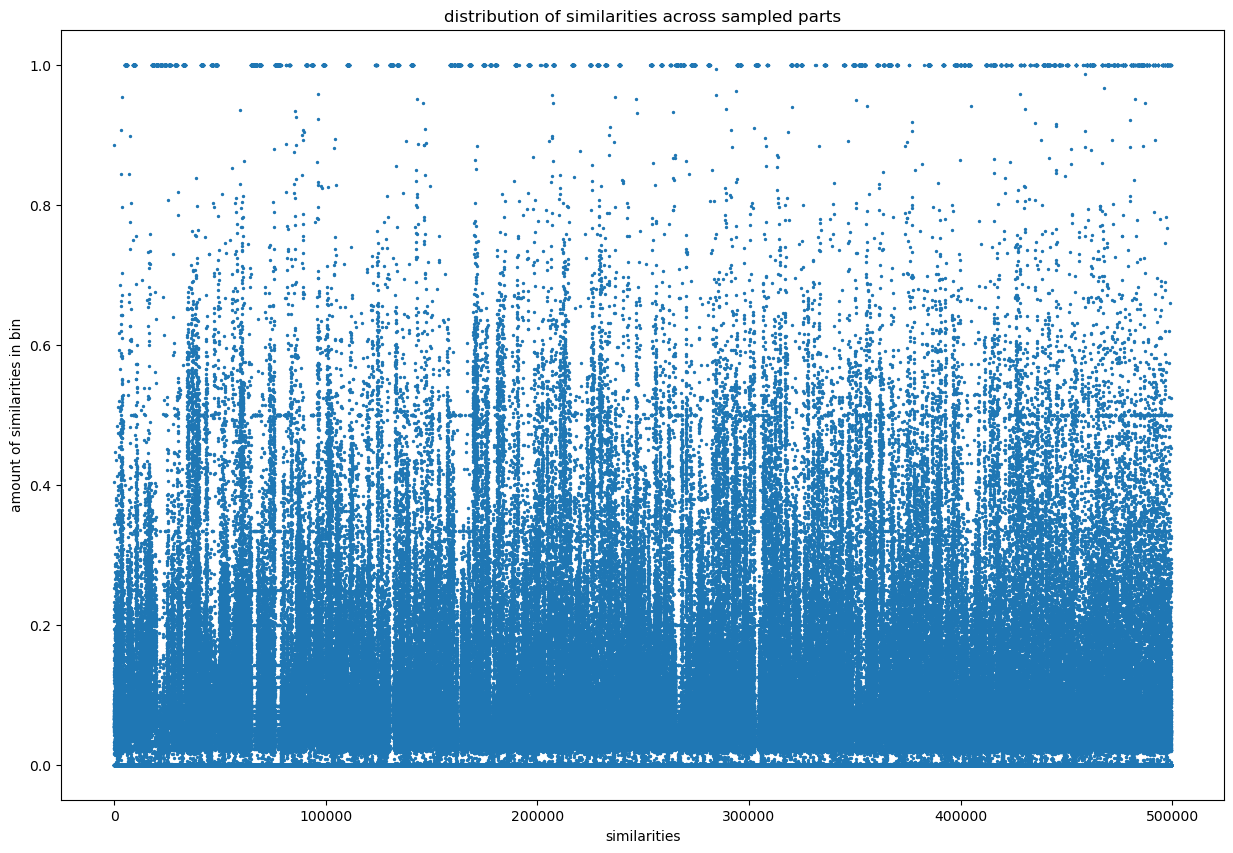

In [56]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(15,10))
ax.scatter(range(0, len(sample_sims)), sample_sims, s=2)
ax.set_xlabel('similarities', fontsize=10)
ax.set_ylabel('amount of similarities in bin', fontsize=10)
ax.set_title('distribution of similarities across sampled parts', fontsize=12)
# plt.tight_layout()
plt.show()

In [58]:
sample_sims_per_cent = [int(sim * 100) for sim in sample_sims]
sample_sims_per_cent

[21,
 8,
 6,
 4,
 0,
 5,
 9,
 10,
 0,
 5,
 8,
 13,
 6,
 7,
 17,
 5,
 15,
 0,
 12,
 0,
 1,
 0,
 2,
 0,
 16,
 0,
 40,
 5,
 0,
 17,
 7,
 2,
 0,
 7,
 7,
 88,
 6,
 5,
 6,
 5,
 12,
 0,
 5,
 6,
 2,
 11,
 0,
 8,
 0,
 5,
 6,
 5,
 19,
 7,
 7,
 0,
 8,
 8,
 22,
 7,
 6,
 6,
 5,
 10,
 23,
 12,
 0,
 0,
 0,
 20,
 0,
 9,
 6,
 5,
 4,
 5,
 7,
 6,
 0,
 0,
 0,
 3,
 34,
 0,
 8,
 2,
 8,
 3,
 8,
 8,
 6,
 14,
 21,
 5,
 0,
 12,
 9,
 0,
 4,
 13,
 6,
 6,
 25,
 0,
 6,
 5,
 7,
 7,
 0,
 9,
 5,
 21,
 5,
 7,
 5,
 6,
 0,
 5,
 4,
 1,
 7,
 13,
 0,
 26,
 8,
 2,
 10,
 5,
 14,
 8,
 4,
 2,
 6,
 0,
 5,
 12,
 7,
 9,
 7,
 0,
 0,
 5,
 6,
 0,
 3,
 10,
 14,
 0,
 6,
 14,
 8,
 0,
 28,
 22,
 8,
 4,
 3,
 6,
 8,
 5,
 8,
 3,
 8,
 2,
 14,
 2,
 4,
 14,
 0,
 6,
 9,
 2,
 6,
 0,
 7,
 0,
 14,
 0,
 0,
 18,
 6,
 0,
 7,
 14,
 0,
 5,
 6,
 6,
 6,
 7,
 8,
 9,
 0,
 4,
 3,
 12,
 0,
 0,
 3,
 0,
 6,
 6,
 8,
 6,
 6,
 4,
 8,
 4,
 8,
 14,
 17,
 0,
 6,
 12,
 0,
 9,
 44,
 9,
 8,
 0,
 16,
 2,
 14,
 14,
 9,
 5,
 0,
 5,
 7,
 0,
 3,
 13,
 17,
 5,
 0,
 5,
 5,
 1

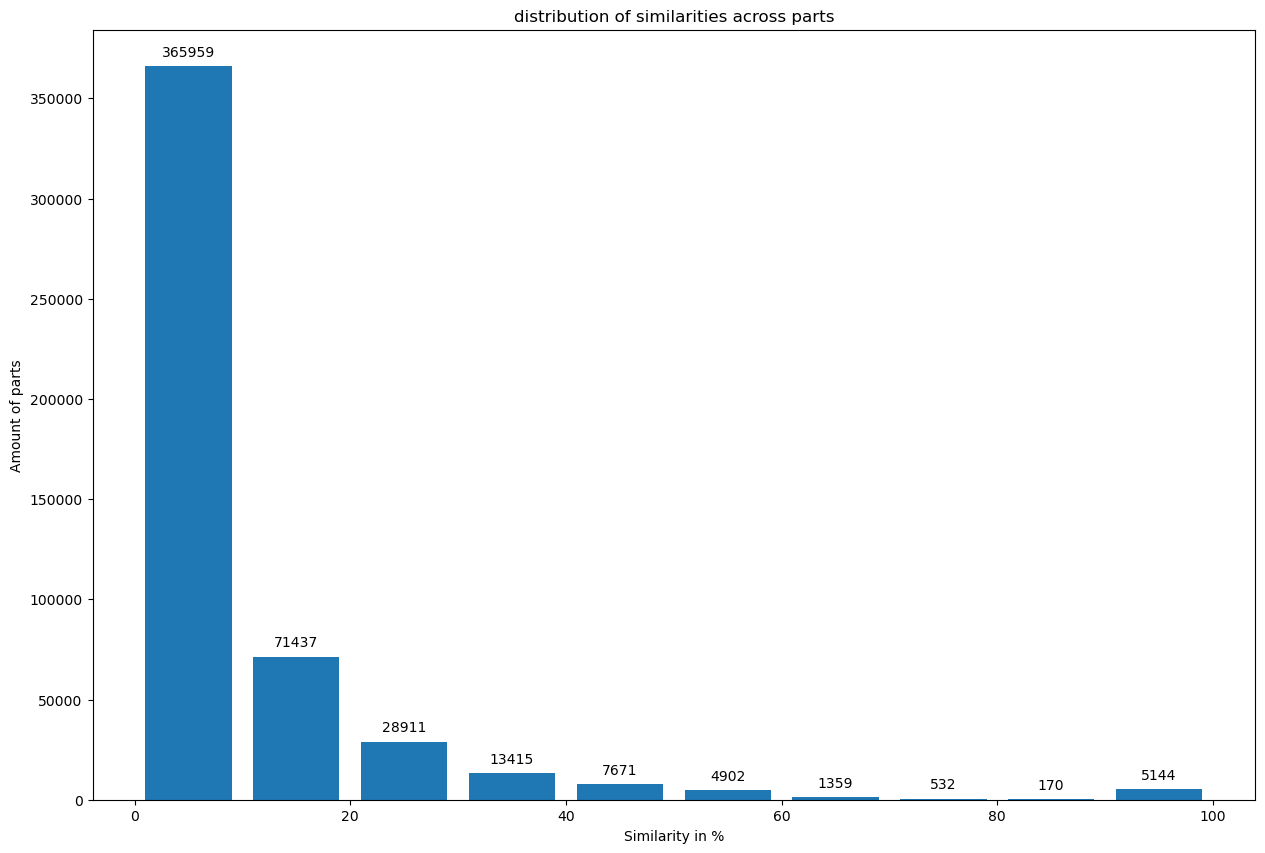

In [62]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
ax.hist(sample_sims_per_cent, bins = range(0, max(sample_sims_per_cent) + 10, 10), rwidth = 0.8)
for rect in ax.patches:
    height = rect.get_height()
    ax.annotate(f'{int(height)}', xy=(rect.get_x()+rect.get_width()/2, height), 
                xytext=(0, 5), textcoords='offset points', ha='center', va='bottom')
ax.set_xlabel('Similarity in %', fontsize=10)
ax.set_ylabel('Amount of parts', fontsize=10)
ax.set_title('distribution of similarities across parts', fontsize=12)
# plt.tight_layout()
plt.show()

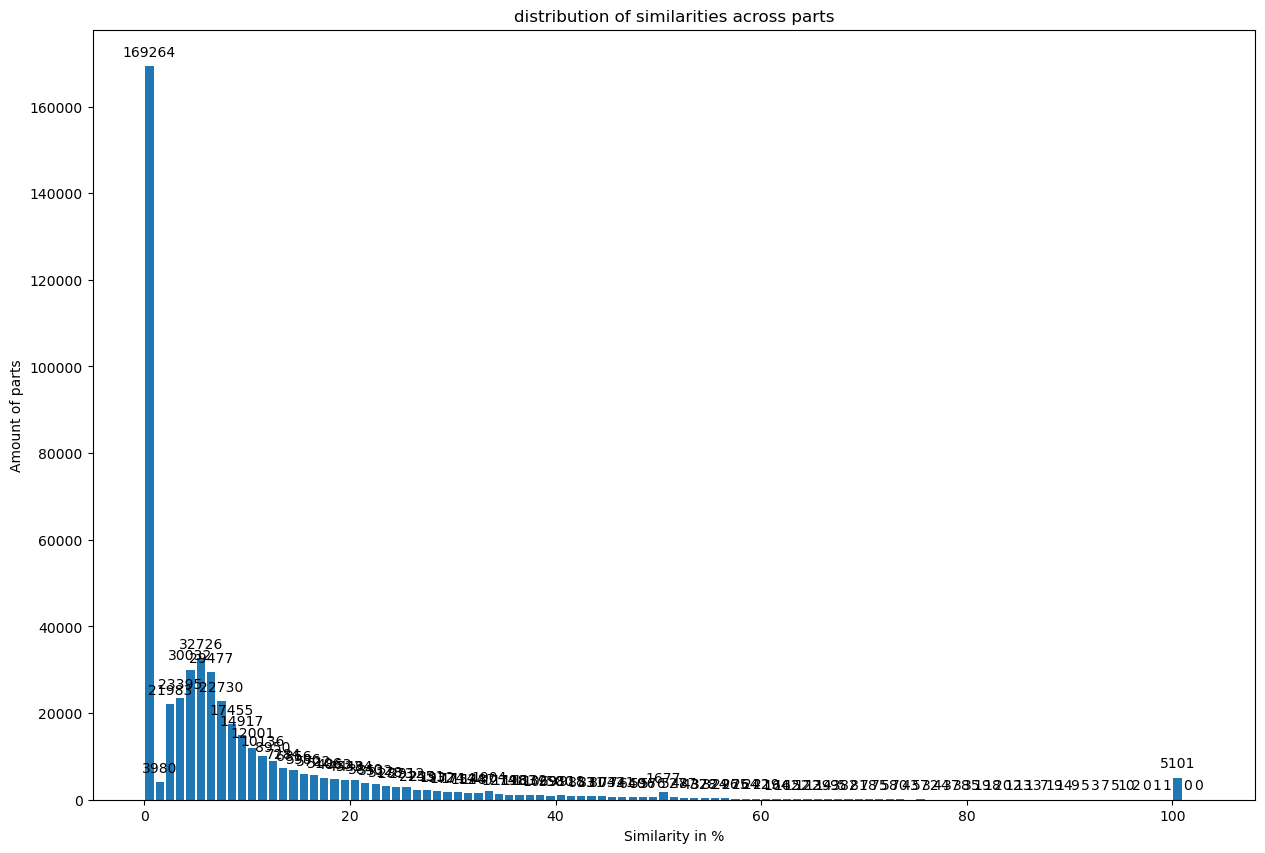

In [67]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
ax.hist(sample_sims_per_cent, bins = range(0, max(sample_sims_per_cent) + 4, 1), rwidth = 0.8)
for rect in ax.patches:
    height = rect.get_height()
    ax.annotate(f'{int(height)}', xy=(rect.get_x()+rect.get_width()/2, height), 
                xytext=(0, 5), textcoords='offset points', ha='center', va='bottom')
ax.set_xlabel('Similarity in %', fontsize=10)
ax.set_ylabel('Amount of parts', fontsize=10)
ax.set_title('distribution of similarities across parts', fontsize=12)
# plt.tight_layout()
plt.show()